# Detecting Facial Keypoints using Convolutional Neural Networks

https://www.kaggle.com/c/facial-keypoints-detection

In [4]:
%matplotlib inline

import os
import sys

import numpy as np
from pandas.io.parsers import read_csv
from scipy import fftpack
from sklearn.utils import shuffle
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
import theano
import cPickle as pickle

import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas.io.parsers import read_csv
from datetime import datetime


from skimage import data, img_as_float
from skimage import exposure


import warnings
warnings.filterwarnings("ignore")

In [7]:
# testRun is defaulted to False
# if testRun is turned to True, change all epochs to 10
# this to help see if there are any errors in the code before running experiments
testRun = True

FTRAIN = 'training.csv'
FTEST = 'test.csv'

bad_train_data = [6492,6493,2321,3296,5556,1877,2289,2199,4263,4828,2194,1907,4490,2090,1747]

def load(test=False, cols=None, ignore=bad_train_data, dropna=True, shuffle_data=True):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe
    
    if not test:
        df.drop(ignore) # delete bad rows in training data
    
    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    if dropna:
        df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    y = None
    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        if shuffle_data:
            X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
            
    return X, y

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)
    
    
# Class to display list as HTML Table in Jupyter Notebook
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [10]:
# common_cols = ["left_eye_center_x", "left_eye_center_y", "right_eye_center_x", "right_eye_center_y",
#                "nose_tip_x", "nose_tip_y", "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y"]

# X, y = load(cols = common_cols)
# print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
# print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

# Load Full data
Full_X, Full_Y = load(ignore=[], dropna=False, shuffle_data=False)

# Load good data
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

# Load Test data
Test_X, _ = load(test=True)

X.shape == (2140, 9216); X.min == 0.000; X.max == 1.000
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


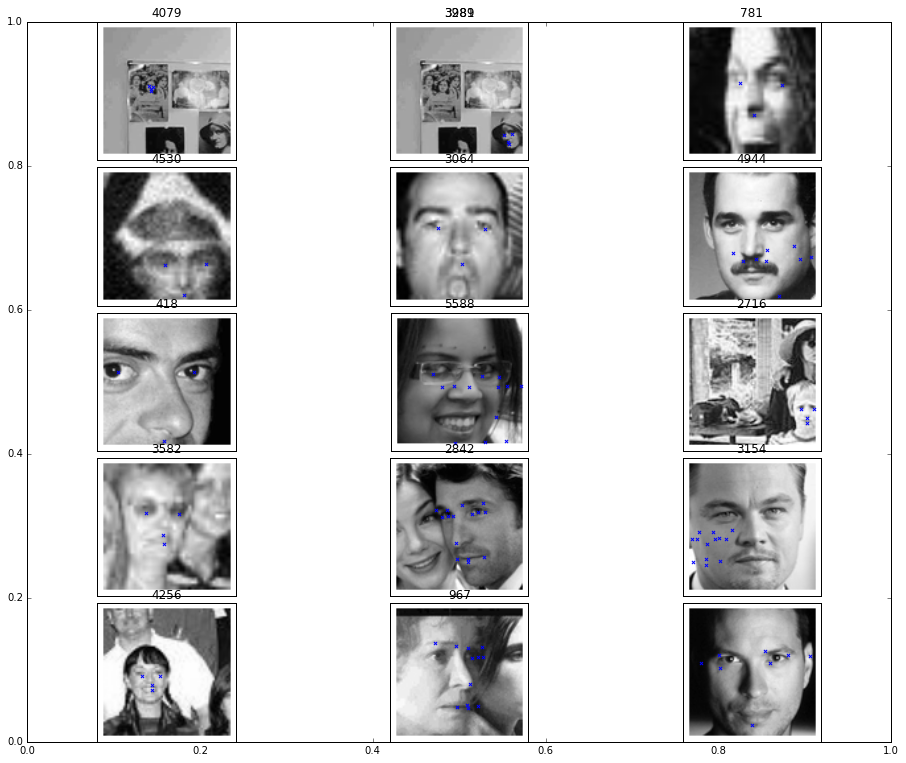

In [11]:
fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(bad_train_data)):
    plt.title(worst[i])
    ax = fig.add_subplot(5, 3, i+1, xticks=[], yticks=[])
    plot_sample(Full_X[bad_train_data[i]], Full_Y[bad_train_data[i]], ax)
plt.show()

Net1:  Single hidden layer NeuralNet (hidden_num_units=100)
First, we compare the performance of single hidden layer NN with variou hidden_layer_number so that we can  choose appropriate number for the following CNN studies.  With the increasing of hidden layer, the training loss will decrease.   However, the validation loss will decrease first and then gradually increase. In additio, with the increasement of hidden number, the computation time for each epcho will increase linearly as well. So in our case, for later CNN, we decided to adopt 300-500 for the number of hidden layer.  

In [ ]:
# a list of hiddern unit number
hidden_num_units = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# Define a listtable to hold statsitical outcomes of NNs with various hiddern unit numbers 
performance_table_1 = ListTable()
performance_table_1.append(['Num_hidden_layer', 'Train_loss', 'Validation_loss', 'Duration_time(s)'])

fig = plt.figure(figsize=(20,8))

for index,num in enumerate(hidden_num_units):
    net1 = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                             ('hidden', layers.DenseLayer),
                             ('output', layers.DenseLayer),],
                     input_shape=(None, 9216),  # 96x96 input pixels per batch
                     #hidden_num_units=200,  # number of units in hidden layer
                     output_nonlinearity=None,  # output layer uses identity function
                     output_num_units=30,  # 30 target values
                     
                     update=nesterov_momentum, # optimization parameters
                     update_learning_rate=0.01,
                     update_momentum=0.9,
                     
                     regression=True,  # flag to indicate we're dealing with regression problem
                     max_epochs=1000,  # we want to train this many epochs
                     verbose=0,)
    net1.hidden_num_units = num
    net1.fit(X, y)
    
    train_loss = np.array([i["train_loss"] for i in net1.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
    print net1.hidden_num_units 
    print "Train, valid errors and computational time of last epcho: %0.4f, %0.4f, %0.4f" %(net1.train_history_[-1]["train_loss"], net1.train_history_[-1]["valid_loss"], net1.train_history_[-1]["dur"])
    performance_table_1.append([net1.hidden_num_units,
                                round(net1.train_history_[-1]["train_loss"],5),
                                round(net1.train_history_[-1]["valid_loss"],5),
                                round(net1.train_history_[-1]["dur"],5)] )
    
    subfig = fig.add_subplot(2, 5, index+1, xticks=[], yticks=[])
    plt.plot(train_loss, linewidth=3, color="blue", linestyle="dashed", label="train")
    plt.plot(valid_loss, linewidth=3, color="blue", linestyle="solid", label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(5*1e-4, 1e-2)
    plt.xlim(0,1000)
    plt.yscale("log")
    subfig.set_title('Num_Hidden_Layer: ' + str(num))

plt.show()
performance_table_1  

Train, valid errors and computational time of last epcho: 0.00136, 0.00319, 0.0878


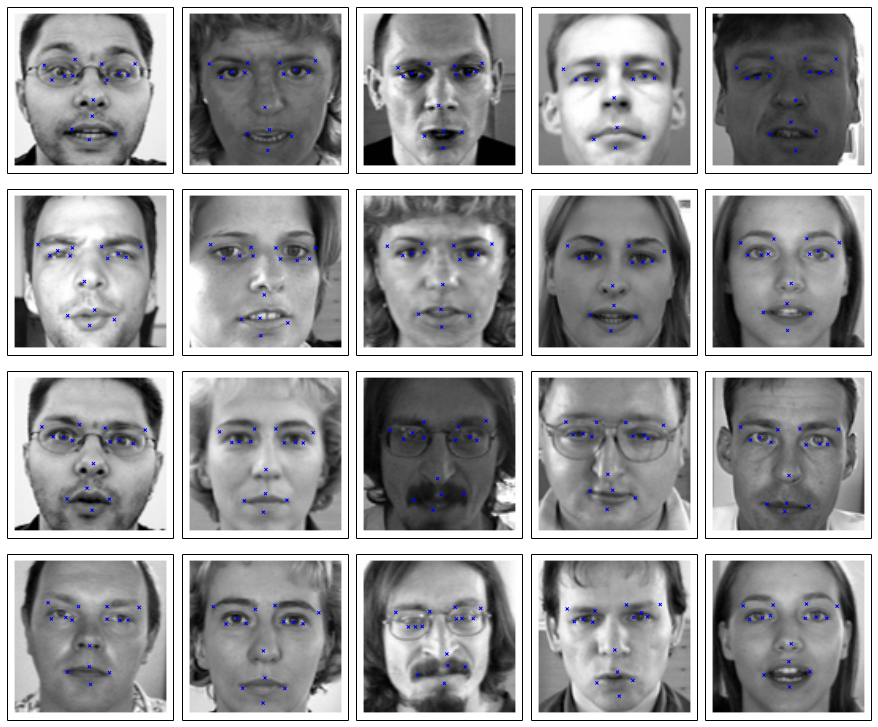

In [23]:
# Build a single layer hidden NN for comparision
net1 = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=500,  # we want to train this many epochs
                 verbose=0,)

net1.fit(X, y)
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1.train_history_[-1]["train_loss"], net1.train_history_[-1]["valid_loss"], net1.train_history_[-1]["dur"])

Test_y_pred = net1.predict(Test_X)

fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Show the predicted labels on test data
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    plot_sample(Test_X[i], Test_y_pred[i], ax)

plt.show()

The following codes will perform the following image normalization  to improve contrast in images: Histrogram Stretching, Histogram Eqaulization. 

In [16]:
X_stretch = np.empty_like(X)
X_eq = np.empty_like(X)
X_adapteq = np.empty_like(X)

#  Histrogram Stretching
for i in range(X.shape[0]):
    img = X[i,]
    p_lowbound, p_upperbound = np.percentile(img, (1, 99))
    X_stretch[i,] = exposure.rescale_intensity(img, in_range=(p_lowbound,p_upperbound ))

#  Histogram Eqaulizatio
for i in range(X.shape[0]):
    img = X[i,]
    X_eq[i,] =  exposure.equalize_hist(img,nbins=255)

# Adaptive Histogram Equalization
#for i in range(X.shape[0]):
#    img = X[i,].reshape(96,96)
#    X_adapteq[i,] =  exposure.equalize_adapthist(img, clip_limit=0.03).flatten()


Fit the new normalization data into the net1

In [24]:
net1_stretch = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=500,  # we want to train this many epochs
                 verbose=0,)

net1_stretch.fit(X_stretch, y)
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1_stretch.train_history_[-1]["train_loss"], net1_stretch.train_history_[-1]["valid_loss"], net1_stretch.train_history_[-1]["dur"])


net1_eq = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=500,  # we want to train this many epochs
                 verbose=0,)
net1_eq.fit(X_eq, y)
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1_eq.train_history_[-1]["train_loss"], net1_eq.train_history_[-1]["valid_loss"], net1_eq.train_history_[-1]["dur"])


Train, valid errors and computational time of last epcho: 0.00145, 0.00283, 0.0883
Train, valid errors and computational time of last epcho: 0.00129, 0.00223, 0.0877


Check whether the normalizaiton transform improve the validation loss.  As shown in the below figure, the Histogram Eqaulization 
 improve the performance of single hidden NN. 

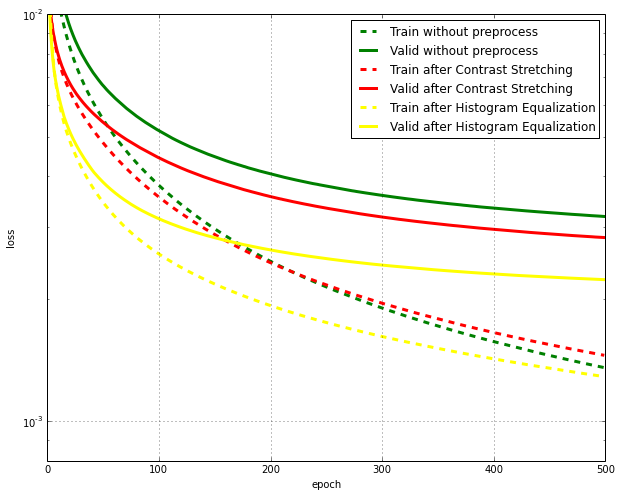

Preprocess,Train_loss,Validation_loss,Duration_time(s)
Without Preprocessing,0.00136,0.00319,0.08784
Contrast stretching,0.00145,0.00283,0.08827
Histogram equalization,0.00129,0.00223,0.08769


In [25]:
# Extract training and validation loss for various models
net1_train_loss = np.array([i["train_loss"] for i in net1.train_history_])
net1_valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
net1_str_train_loss = np.array([i["train_loss"] for i in net1_stretch.train_history_])
net1_str_valid_loss = np.array([i["valid_loss"] for i in net1_stretch.train_history_])
net1_eq_train_loss = np.array([i["train_loss"] for i in net1_eq.train_history_])
net1_eq_valid_loss = np.array([i["valid_loss"] for i in net1_eq.train_history_])


# Plot for performance comparision between differnt preprocesses
plt.figure(figsize=(10, 8))
plt.plot(net1_train_loss, linewidth=3,  color="green", linestyle="dashed", label="Train without preprocess")
plt.plot(net1_valid_loss, linewidth=3,  color="green", linestyle="solid", label="Valid without preprocess")
plt.plot(net1_str_train_loss, linewidth=3,  color="red", linestyle="dashed", label="Train after Contrast Stretching")
plt.plot(net1_str_valid_loss, linewidth=3,  color="red", linestyle="solid", label="Valid after Contrast Stretching")
plt.plot(net1_eq_train_loss, linewidth=3,  color="yellow", linestyle="dashed", label="Train after Histogram Equalization")
plt.plot(net1_eq_valid_loss, linewidth=3,  color="yellow", linestyle="solid", label="Valid after Histogram Equalization")

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(8*1e-4, 1e-2)
plt.yscale("log")

plt.show()

# Define a listtable to hold statsitical outcomes of NNs with various preprocessing steps 
performance_table_2 = ListTable()
performance_table_2.append(['Preprocess', 'Train_loss', 'Validation_loss', 'Duration_time(s)'])
performance_table_2.append(['Without Preprocessing',
                            round(net1.train_history_[-1]["train_loss"],5),
                            round(net1.train_history_[-1]["valid_loss"],5),
                            round(net1.train_history_[-1]["dur"],5)] )
performance_table_2.append(['Contrast stretching',
                            round(net1_stretch.train_history_[-1]["train_loss"],5),
                            round(net1_stretch.train_history_[-1]["valid_loss"],5),
                            round(net1_stretch.train_history_[-1]["dur"],5)] )    
performance_table_2.append(['Histogram equalization',
                            round(net1_eq.train_history_[-1]["train_loss"],5),
                            round(net1_eq.train_history_[-1]["valid_loss"],5),
                            round(net1_eq.train_history_[-1]["dur"],5)] )   
performance_table_2  


In [ ]:
#net2_epochs = 10 if testRun else 750

net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=500,
    verbose=1,
    )

X2d = X.reshape(-1, 1, 96, 96) # reshape image values
net2.fit(X2d, y)
# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:
with open('net2.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)

In [ ]:
sample1 = load(test=True)[0][6:7]
sample2 = sample1.reshape(-1, 1, 96, 96)
y_pred1 = net1.predict(sample1)[0]
y_pred2 = net2.predict(sample2)[0]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred2, ax)
plt.show()

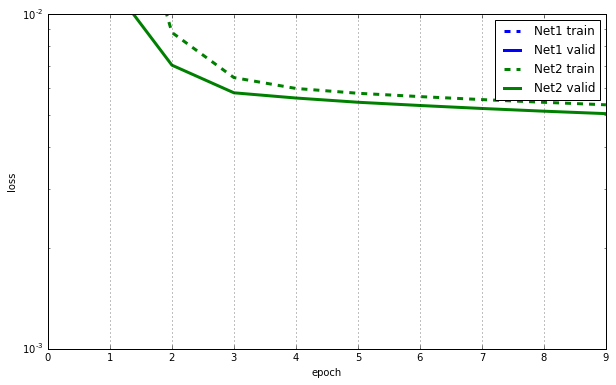

In [10]:
net1_train_loss = np.array([i["train_loss"] for i in net1.train_history_])
net1_valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
net2_train_loss = np.array([i["train_loss"] for i in net2.train_history_])
net2_valid_loss = np.array([i["valid_loss"] for i in net2.train_history_])

plt.figure(figsize=(10, 6))
plt.plot(net1_train_loss, linewidth=3, color="blue", linestyle="dashed", label="Net1 train")
plt.plot(net1_valid_loss, linewidth=3, color="blue", linestyle="solid", label="Net1 valid")
plt.plot(net2_train_loss, linewidth=3, color="green", linestyle="dashed", label="Net2 train")
plt.plot(net2_valid_loss, linewidth=3, color="green", linestyle="solid",label="Net2 valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1e-2)
plt.yscale("log")

plt.show()

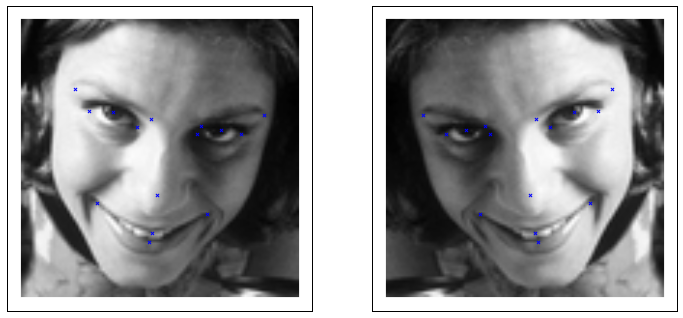

In [14]:
X_flipped = X2d[:, :, :, ::-1]  # simple slice to flip all images
y_flipped = np.array(y)
for labels in y_flipped:
    labels[0::2] = -labels[0::2] # flip only the x coordinates
    
# plot two images:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[1], y[1], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1], y_flipped[1], ax)
plt.show()

In [42]:

class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

Net5:  

In [49]:
# def float32(k):
#     return np.cast['float32'](k)

# class AdjustVariable(object):
#     def __init__(self, name, start=0.03, stop=0.001):
#         self.name = name
#         self.start, self.stop = start, stop
#         self.ls = None

#     def __call__(self, nn, train_history):
#         if self.ls is None:
#             self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

#         epoch = train_history[-1]['epoch']
#         new_value = float32(self.ls[epoch - 1])
#         getattr(nn, self.name).set_value(new_value)

# net4 = NeuralNet(
#     layers=[
#         ('input', layers.InputLayer),
#         ('conv1', layers.Conv2DLayer),
#         ('pool1', layers.MaxPool2DLayer),
#         ('conv2', layers.Conv2DLayer),
#         ('pool2', layers.MaxPool2DLayer),
#         ('conv3', layers.Conv2DLayer),
#         ('pool3', layers.MaxPool2DLayer),
#         ('hidden4', layers.DenseLayer),
#         ('hidden5', layers.DenseLayer),
#         ('output', layers.DenseLayer),
#         ],
#     input_shape=(None, 1, 96, 96),
#     conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
#     conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
#     conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
#     hidden4_num_units=500, hidden5_num_units=500,
#     output_num_units=30, output_nonlinearity=None,
    
#     update_learning_rate=theano.shared(float32(0.03)),
#     update_momentum=theano.shared(float32(0.9)),
    
#     regression=True,
#     # batch_iterator_train=FlipBatchIterator(batch_size=128),
#     on_epoch_finished=[
#         AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
#         AdjustVariable('update_momentum', start=0.9, stop=0.999),
#         ],
#     max_epochs=750,
#     verbose=1,
#     )

# X, y = load2d()
# net4.fit(X, y)

# with open('net4.pickle', 'wb') as f:
#     pickle.dump(net4, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [67]:
# net5 = NeuralNet(
#     layers=[
#         ('input', layers.InputLayer),
#         ('conv1', layers.Conv2DLayer),
#         ('pool1', layers.MaxPool2DLayer),
#         ('conv2', layers.Conv2DLayer),
#         ('pool2', layers.MaxPool2DLayer),
#         ('conv3', layers.Conv2DLayer),
#         ('pool3', layers.MaxPool2DLayer),
#         ('hidden4', layers.DenseLayer),
#         ('hidden5', layers.DenseLayer),
#         ('output', layers.DenseLayer),
#         ],
#     input_shape=(None, 1, 96, 96),
#     conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
#     conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
#     conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
#     hidden4_num_units=500, hidden5_num_units=500,
#     output_num_units=30, output_nonlinearity=None,

#     update_learning_rate=theano.shared(float32(0.03)),
#     update_momentum=theano.shared(float32(0.9)),

#     regression=True,
#     batch_iterator_train=FlipBatchIterator(batch_size=128),
#     on_epoch_finished=[
#         AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
#         AdjustVariable('update_momentum', start=0.9, stop=0.999),
#         ],
#     max_epochs=750,
#     verbose=1,
#     )

# net5.fit(X, y)

# with open('net5.pickle', 'wb') as f:
#     pickle.dump(net5, f, -1)

  input             	(None, 1, 96, 96)   	produces    9216 outputs
  conv1             	(None, 32, 94, 94)  	produces  282752 outputs
  pool1             	(None, 32, 47, 47)  	produces   70688 outputs
  conv2             	(None, 64, 46, 46)  	produces  135424 outputs
  pool2             	(None, 64, 23, 23)  	produces   33856 outputs
  conv3             	(None, 128, 22, 22) 	produces   61952 outputs
  pool3             	(None, 128, 11, 11) 	produces   15488 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 30)          	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.05714       0.01005      5.68781  2.93s
      2       0.00783       0.00650      1.20528  2.94s
      3       0.00606       0.00564      1.07441  2.93s
      4       0.00550       0.00519      1.06052  2.

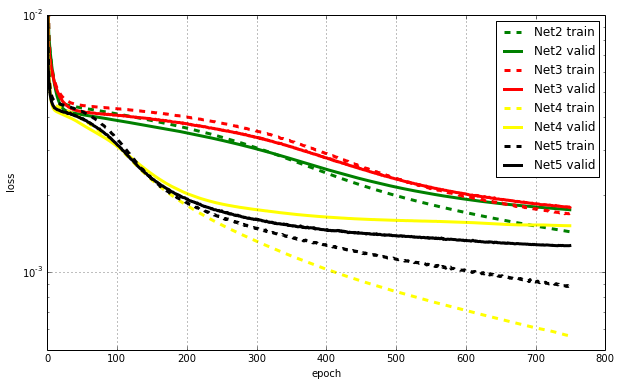

In [89]:

# net2_train_loss = np.array([i["train_loss"] for i in net2.train_history_])
# net2_valid_loss = np.array([i["valid_loss"] for i in net2.train_history_])
# net3_train_loss = np.array([i["train_loss"] for i in net3.train_history_])
# net3_valid_loss = np.array([i["valid_loss"] for i in net3.train_history_])
# net4_train_loss = np.array([i["train_loss"] for i in net4.train_history_])
# net4_valid_loss = np.array([i["valid_loss"] for i in net4.train_history_])
# net5_train_loss = np.array([i["train_loss"] for i in net5.train_history_])
# net5_valid_loss = np.array([i["valid_loss"] for i in net5.train_history_])

# plt.figure(figsize=(10, 6))
# plt.plot(net2_train_loss, linewidth=3,  color="green", linestyle="dashed", label="Net2 train")
# plt.plot(net2_valid_loss, linewidth=3,  color="green", linestyle="solid", label="Net2 valid")
# plt.plot(net3_train_loss, linewidth=3,  color="red", linestyle="dashed", label="Net3 train")
# plt.plot(net3_valid_loss, linewidth=3,  color="red", linestyle="solid", label="Net3 valid")
# plt.plot(net4_train_loss, linewidth=3,  color="yellow", linestyle="dashed", label="Net4 train")
# plt.plot(net4_valid_loss, linewidth=3,  color="yellow", linestyle="solid", label="Net4 valid")
# plt.plot(net5_train_loss, linewidth=3,  color="black", linestyle="dashed", label="Net5 train")
# plt.plot(net5_valid_loss, linewidth=3,  color="black", linestyle="solid", label="Net5 valid")

# plt.grid()
# plt.legend()
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.ylim(5*1e-4, 1e-2)
# plt.yscale("log")

# plt.show()

In [86]:
np.sqrt(0.00127) * 48


1.7105788493957244

It is clear that in this case Net4 is overfitting, which need further regularization.  Although the deegree of overfitting in Net5 is not as severe as Net4, it can become worse when the model is trained with longer epoch.  Therefore, at the next step, the dropout layers are added to regularize the Net4 model.  (Remember that after the dropout layers are added, the train error will be evaluated with dropout, whereas the validation error is still evaluated without dropout. )

In [91]:
net6 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  # !
    hidden4_num_units=500,
    dropout4_p=0.5,  # !
    hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=750,
    verbose=1,
    )

In [92]:
sys.setrecursionlimit(10000)

net6.fit(X2d, y)

with open('net6.pickle', 'wb') as f:
net2_train_loss = np.array([i["train_loss"] for i in net2.train_history_])
net2_valid_loss = np.array([i["valid_loss"] for i in net2.train_history_])    pickle.dump(net6, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

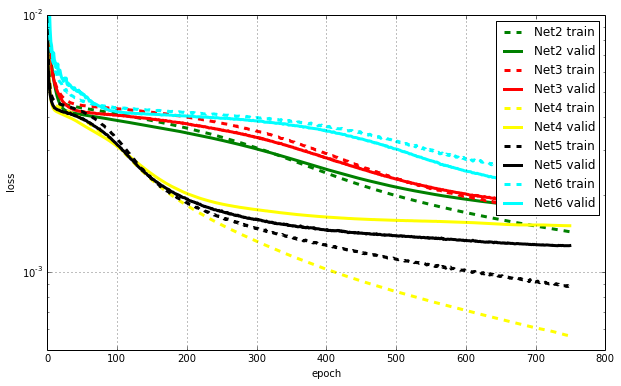

In [93]:
net1_train_loss = np.array([i["train_loss"] for i in net1.train_history_])
net1_valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])

# net2_train_loss = np.array([i["train_loss"] for i in net2.train_history_])
# net2_valid_loss = np.array([i["valid_loss"] for i in net2.train_history_])
# net3_train_loss = np.array([i["train_loss"] for i in net3.train_history_])
# net3_valid_loss = np.array([i["valid_loss"] for i in net3.train_history_])
# net4_train_loss = np.array([i["train_loss"] for i in net4.train_history_])
# net4_valid_loss = np.array([i["valid_loss"] for i in net4.train_history_])
# net5_train_loss = np.array([i["train_loss"] for i in net5.train_history_])
# net5_valid_loss = np.array([i["valid_loss"] for i in net5.train_history_])
net6_train_loss = np.array([i["train_loss"] for i in net6.train_history_])
net6_valid_loss = np.array([i["valid_loss"] for i in net6.train_history_])

plt.figure(figsize=(10, 6))
plt.plot(net1_train_loss, linewidth=3,  color="green", linestyle="dashed", label="Net1 train")
plt.plot(net1_valid_loss, linewidth=3,  color="green", linestyle="solid", label="Net1 valid")
# plt.plot(net2_train_loss, linewidth=3,  color="green", linestyle="dashed", label="Net2 train")
# plt.plot(net2_valid_loss, linewidth=3,  color="green", linestyle="solid", label="Net2 valid")
# plt.plot(net3_train_loss, linewidth=3,  color="red", linestyle="dashed", label="Net3 train")
# plt.plot(net3_valid_loss, linewidth=3,  color="red", linestyle="solid", label="Net3 valid")
# plt.plot(net4_train_loss, linewidth=3,  color="yellow", linestyle="dashed", label="Net4 train")
# plt.plot(net4_valid_loss, linewidth=3,  color="yellow", linestyle="solid", label="Net4 valid")
# plt.plot(net5_train_loss, linewidth=3,  color="black", linestyle="dashed", label="Net5 train")
# plt.plot(net5_valid_loss, linewidth=3,  color="black", linestyle="solid", label="Net5 valid")
plt.plot(net6_train_loss, linewidth=3,  color="cyan", linestyle="dashed", label="Net6 train")
plt.plot(net6_valid_loss, linewidth=3,  color="cyan", linestyle="solid", label="Net6 valid")

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(5*1e-4, 1e-2)
plt.yscale("log")

plt.show()

*Defining "Accuracy"*
Understand what Daniel means by:
The net1 object actually keeps a record of the data that it prints out in the table. We can access that record through the train_history_ attribute. Let's draw those two curves:

*Data Cleaning* 

Alex: - remove images that are constantly predicted wrong

*PREPROCESSING*:
Overall conclusion - preprocessing doesn't help too much on CNN, as the feature layers automatically generate "features".

// Minghu - Add in Yuhang's DCT HFF
Minghu - Add in Histogram scaling as pre-processing

*in Net6:*

Yuhang - Add in removing Pooling layer, increasing filter size
Sidd - [CONV -> Threshold -> CONV -> Threshold -> POOL]*3 -> [FC -> Threshold]*2
Byron - L2 regularization vs L2 Pooling?

# Stack conv layer directly 
input -> conv 3 * 3 * 32 -> conv 5 * 5 * 64 -> pool 2 * 2 -> dropout 0.1 -> conv 2 * 2 * 128 -> pool 2 * 2 -> dropout 0.1 -> FC 500 -> output

In [ ]:
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

def load2dFilter(l = 5):
    X, y = load()
    newX = np.empty_like(X)
    for i in range(X.shape[0]):
        newX[i] = idct2(primHPF(dct2(X[i]), level=l)).reshape(96 * 96)
    newX = newX.reshape(-1, 1, 96, 96)
    
    return newX, y

def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

deepNet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('conv2', layers.Conv2DLayer),
        #('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('conv5', layers.Conv2DLayer),
        ('pool6', layers.MaxPool2DLayer),
        ('dropout6', layers.DropoutLayer),  # !
        #('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3),
    conv2_num_filters=64, conv2_filter_size=(5, 5),
    #conv3_num_filters=128, conv3_filter_size=(3, 3),
    pool3_pool_size=(2, 2),
    dropout3_p=0.1,  # !
    conv5_num_filters=128, conv5_filter_size=(2, 2),
    pool6_pool_size=(2, 2),
    dropout6_p=0.1,  # !
    #hidden4_num_units=500,
    hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    #batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=750,
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
deepNet2.fit(X, y)

with open('deepNet2.pickle', 'wb') as f:
    pickle.dump(deepNet2, f, -1)


# Similar to deepNet2 but with smaller conv filter size.

In [ ]:
deepNet1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('conv2', layers.Conv2DLayer),
        #('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('conv5', layers.Conv2DLayer),
        ('pool6', layers.MaxPool2DLayer),
        ('dropout6', layers.DropoutLayer),  # !
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(3, 3),
    #conv3_num_filters=128, conv3_filter_size=(3, 3),
    pool3_pool_size=(2, 2),
    dropout3_p=0.1,  # !
    conv5_num_filters=256, conv5_filter_size=(2, 2),
    pool6_pool_size=(3, 3),
    dropout6_p=0.1,  # !
    hidden4_num_units=500,
    hidden5_num_units=300,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    #batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=750,
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
deepNet1.fit(X, y)

with open('deepNet1.pickle', 'wb') as f:
    pickle.dump(deepNet1, f, -1)


# Augment training set by doing DCT -> LPF/HPF -> iDCT

In [ ]:

def dct2(xIn, xDim = 96, yDim = 96):
    #dctback = fftpack.idct(dct)

    return fftpack.dct(fftpack.dct(xIn.reshape(xDim,yDim), norm = 'ortho').T, norm = 'ortho')

def idct2(xIn2Dim):
    return fftpack.idct(fftpack.idct(xIn2Dim, norm = 'ortho').T, norm = 'ortho')

def primHPF(xIn2Dim, level = 5):
    shape0 = xIn2Dim.shape[0]
    shape1 = xIn2Dim.shape[1]
    
    for i in range(shape0 - level, shape0):
        for j in range(shape1 - level, shape1):
            xIn2Dim[i,j] = 0
    return xIn2Dim

def primLPF(xIn2Dim, level = 5):
    for i in range(level):
        for j in range(level):
            xIn2Dim[i,j] = 0
    return xIn2Dim

def load2dHPFFilter(l = 5):
    X, y = load()
    newX = np.empty_like(X)
    for i in range(X.shape[0]):
        newX[i] = idct2(primHPF(dct2(X[i]), level=l)).reshape(96 * 96)
    newX = newX.reshape(-1, 1, 96, 96)
    
    return newX, y

def load2dLPFFilter(l = 5):
    X, y = load()
    newX = np.empty_like(X)
    for i in range(X.shape[0]):
        newX[i] = idct2(primLPF(dct2(X[i]), level=l)).reshape(96 * 96)
    newX = newX.reshape(-1, 1, 96, 96)
    
    return newX, y

def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)



net6dctstack = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  # !
    hidden4_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    #batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=750 * 5,
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
#net6.fit(X, y)

hpf10, y = load2dHPFFilter(l=10)
hpf5, y = load2dHPFFilter(l=5)
lpf5, y = load2dLPFFilter(l=5)
lpf10, y = load2dLPFFilter(l=10)
net6dctstack.fit(hpf10, y)
net6dctstack.fit(hpf5, y)
net6dctstack.fit(lpf5, y)
net6dctstack.fit(lpf10, y)
net6dctstack.fit(X, y)

with open('net6dctstack.pickle', 'wb') as f:
    pickle.dump(net6dctstack, f, -1)